In [12]:
import warnings
import math
import keras
import h5py
import scipy
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pywt

import src.preprocess
import src.cwt_pywt

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
def minibatch_c(x, 
                f: h5py.File, 
                dbname: str,
                batch_size=64,
                vmin = 1.2,
                vmax = -1):
    """
    Fills a h5py dataset in the open file with the CWT images from x.

    x - eeg signal data (modify before inputting) \n
    f - open h5py.File 
    """
    shape = (x.shape[0], 299, 299, 3)
    db = f.create_dataset(dbname, shape = shape, dtype=np.dtype('B'))
    for i in tqdm.trange((math.ceil(x.shape[0] / batch_size)), desc="Filling {}".format(dbname), colour='green'):
        with warnings.catch_warnings(action="ignore"):
            cwt = src.cwt_pywt.CWT_PYWT(x[i*batch_size:(i+1)*batch_size], vmin=vmin, vmax=vmax)
        cwt.fill_db(db, i*batch_size)

In [14]:
"""
def get_max_coefs():
    max_coef = np.zeros((22))
    for c in range(x_train.shape[1]):
        for i in range(int(math.ceil(x_train.shape[0] / 64))):
            cwt = src.cwt_pywt.CWT_PYWT(x_train[i*64:(i+1)*64,c])
            max_coef[c] = max(max_coef[c], np.max(cwt.coefs_abs))
    return max_coef
"""

"""
[139.97690651 114.21430515 119.97032405 124.84658604 103.89086066
 116.04049364 129.05667749 129.28167161  86.45805181  84.37512111
  76.52058592 141.2054457  144.76946249 158.82758407 119.59655741
 104.72203624 119.32650503 157.94002717 207.08483998 172.21956901
 172.94622795 221.69340731]
"""

max_coef = np.array([139.97690651, 114.21430515, 119.97032405, 124.84658604, 103.89086066,
                     116.04049364, 129.05667749, 129.28167161,  86.45805181, 84.37512111,
                     76.52058592, 141.2054457,  144.76946249, 158.82758407, 119.59655741,
                     104.72203624, 119.32650503, 157.94002717, 207.08483998, 172.21956901,
                     172.94622795, 221.69340731])

In [15]:
def create_x_h5(x_train, x_valid, x_test, channels, vmins, vmaxs):
    for c in channels:
        f = h5py.File('inceptionv3_c{}.h5'.format(c), 'w-')
        minibatch_c(x_train[:,c], f, 'x_train', vmin=vmins[c], vmax=vmaxs[c])
        minibatch_c(x_valid[:,c], f, 'x_valid', vmin=vmins[c], vmax=vmaxs[c])
        minibatch_c(x_test[:,c], f, 'x_test', vmin=vmins[c], vmax=vmaxs[c])
        f.close()

def create_y_h5(y_train, y_valid, y_test):
    f = h5py.File('inceptionv3_y.h5', 'w-')
    f.create_dataset('y_train', data=y_train, dtype=np.dtype('B'))
    f.create_dataset('y_valid', data=y_valid, dtype=np.dtype('B'))
    f.create_dataset('y_test', data=y_test, dtype=np.dtype('B'))
    f.close()

Filling x_valid:  10%|█         | 12/116 [01:27<12:34,  7.25s/it]


KeyboardInterrupt: 

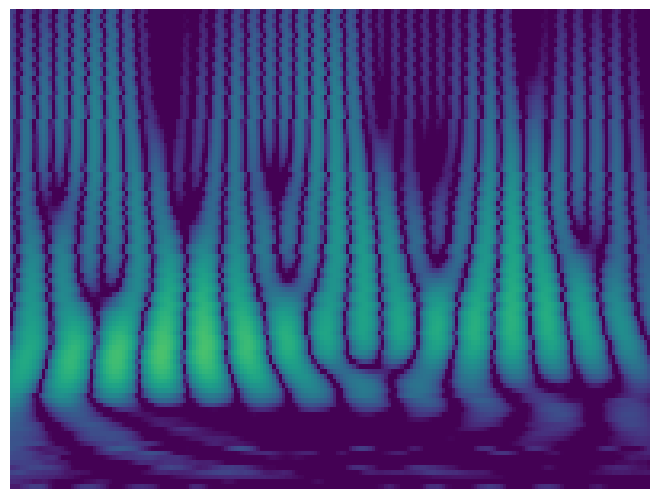

In [16]:
with h5py.File('raw.h5', 'r') as f:
    x_train = f['x_train']
    try:
        create_y_h5(f['y_train'], f['y_valid'], f['y_test'])
    except FileExistsError:
        pass

    create_x_h5(x_train=f['x_train'],
                x_valid=f['x_valid'], 
                x_test=f['x_test'],
                channels=[3],
                vmins = np.repeat([1.2], 22),
                vmaxs = max_coef)
    